In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.functional as F
import pickle
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import spacy
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random
from tqdm.auto import tqdm

RANDOM_STATE = 5411
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device="cpu"

In [2]:
torch.cuda.manual_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
# torch.cuda.set_device(device)

In [3]:
data = pickle.load(open("data/data.pkl", "rb"))

In [4]:
def preprocess(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text)
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(r"#[A-Za-z0-9]*", "", text)
    text = re.sub(r"https?:\/\/\S+", "", text)
    text = re.sub(r"[\n]", " ", text)
    # text = re.sub(r"[.*/]", " ", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    return text.strip()

In [5]:
data = [[preprocess(i[0]), i[1]] for i in data]

In [6]:
tokenizer = get_tokenizer("spacy")

c:\Users\aritr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [7]:
def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

In [8]:
vocab = build_vocab_from_iterator(yield_tokens(data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [9]:
len(vocab)

23160

In [10]:
stoi = lambda x: vocab(tokenizer(x))

In [11]:
vocab.get_itos()[0]

'<unk>'

In [12]:
tokenizer("<unk>")

['<', 'unk', '>']

In [13]:
# import pandas as pd

# glove = pd.read_csv('D:/Downloads/glove.840B.300d/glove.840B.300d.txt', sep=" ", quoting=3, header=None, index_col=0)

In [14]:
# glove.head(5)

In [15]:

# glove_embedding = {key: val.values for key, val in glove.T.items()}

In [16]:
# len(glove_embedding[','])

In [17]:
stoi(",")

[3]

In [18]:
# embedding_matrix = torch.zeros((len(vocab), 300))

# for i in range(1, len(vocab)):
#     word = vocab.get_itos()[i]
#     if word in glove_embedding:
#         embedding_matrix[i]=torch.from_numpy(glove_embedding[word])

In [19]:
# embedding_matrix[:5]

In [20]:
# pickle.dump(embedding_matrix,open("embeddings.pkl","wb"))

In [21]:
x=pickle.load(open("embeddings.pkl","rb"))

In [22]:
type(x)

torch.Tensor

In [23]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]

    for _text, _label in batch:
        label_list.append(_label)
        processed_text = torch.tensor(stoi(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)

    return label_list.to(device), text_list.to(device), offsets.to(device)

In [24]:
data = random.sample(data, len(data))

In [25]:
split = 0.2
split_index = int(len(data) * (1 - split))

In [26]:
train_data, test_data = data[:split_index], data[split_index:]

In [27]:
type(train_data)

list

In [28]:
len(train_data), len(test_data)

(2257, 565)

In [29]:
BATCH_SIZE = 16

In [30]:
train_dataloader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch,generator=torch.Generator(device=device)
)

In [31]:
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch,
    generator=torch.Generator(device=device),
)

In [32]:
from torch import nn


class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_nodes, num_class):
        super(TextClassificationModel, self).__init__()

        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.dense_block = nn.Sequential(
            nn.Linear(embed_dim, num_nodes),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(num_nodes, num_class),
        )

        self.embedding.apply(self.init_weights)
        self.dense_block.apply(self.init_weights)

    def init_weights(self, layer):
        initrange = 0.5

        if isinstance(layer, nn.Linear):
            layer.weight.data.uniform_(-initrange, initrange)
            layer.bias.data.zero_()
        elif isinstance(layer, nn.EmbeddingBag):
            layer.weight.data.uniform_(-initrange, initrange)

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.dense_block(embedded)

In [33]:
num_class = 2
vocab_size = len(vocab)
embed_size = 64
model = TextClassificationModel(vocab_size, embed_size, 512, num_class).to(device)

In [34]:
EPOCHS = 20
LR = 0.001

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [36]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (y, X, offsets) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X, offsets)

        # 2. Calculating and accumulating loss
        loss = loss_fn(y_pred, y)

        l2_lambda = 0.001
        l2_regularization = torch.tensor(0.0, requires_grad=True)
        for name, param in model.named_parameters():
            if "bias" not in name:
                l2_regularization = l2_regularization + torch.norm(param, p=2)

        loss = loss + l2_lambda * l2_regularization
        
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        # print(y_pred, y_pred_class, train_prec, "\n")
        # break

    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (y, X, offsets) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X, offsets)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)

            l2_lambda = 0.001
            l2_regularization = torch.tensor(0.0, requires_grad=True)
            for name, param in model.named_parameters():
                if "bias" not in name:
                    l2_regularization = l2_regularization + torch.norm(param, p=2)
            loss = loss + l2_lambda * l2_regularization

            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

            # break

    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
):
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device
        )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [37]:
next(iter(train_dataloader))

(tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]),
 tensor([ 130,   51,   73,  ...,   13, 1053,   36]),
 tensor([   0,  328,  567,  819, 1168, 1623, 1848, 2067, 2396, 2469, 2712, 3086,
         5497, 5501, 5829, 5872]))

In [38]:
train(model, train_dataloader, test_dataloader, optimizer, criterion, EPOCHS, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9677 | train_acc: 0.6699 | test_loss: 0.8158 | test_acc: 0.7250
Epoch: 2 | train_loss: 0.7218 | train_acc: 0.7746 | test_loss: 0.6284 | test_acc: 0.8000
Epoch: 3 | train_loss: 0.5261 | train_acc: 0.8521 | test_loss: 0.5107 | test_acc: 0.8385
Epoch: 4 | train_loss: 0.4067 | train_acc: 0.8851 | test_loss: 0.4578 | test_acc: 0.8472
Epoch: 5 | train_loss: 0.3175 | train_acc: 0.9217 | test_loss: 0.4226 | test_acc: 0.8347
Epoch: 6 | train_loss: 0.2737 | train_acc: 0.9252 | test_loss: 0.4342 | test_acc: 0.8521
Epoch: 7 | train_loss: 0.2363 | train_acc: 0.9419 | test_loss: 0.4123 | test_acc: 0.8420
Epoch: 8 | train_loss: 0.2158 | train_acc: 0.9476 | test_loss: 0.4306 | test_acc: 0.8517
Epoch: 9 | train_loss: 0.1962 | train_acc: 0.9551 | test_loss: 0.4147 | test_acc: 0.8507
Epoch: 10 | train_loss: 0.1828 | train_acc: 0.9608 | test_loss: 0.4234 | test_acc: 0.8417
Epoch: 11 | train_loss: 0.1761 | train_acc: 0.9595 | test_loss: 0.4263 | test_acc: 0.8420
Epoch: 12 | train_l

{'train_loss': [0.9676783722890935,
  0.7217653830286482,
  0.5261253907646931,
  0.4067090241841867,
  0.3174593069813621,
  0.2736987614820541,
  0.23626421260791766,
  0.21575475977340214,
  0.19623993410610815,
  0.1828182180425231,
  0.17606715627119573,
  0.16246385447366138,
  0.15626275715168933,
  0.15349290210386396,
  0.14901363957201091,
  0.14211448748976413,
  0.14083539510906581,
  0.13329096374587274,
  0.13323777197847064,
  0.13122003664538054],
 'train_acc': [0.6698943661971831,
  0.7746478873239436,
  0.852112676056338,
  0.8851232394366197,
  0.9216549295774648,
  0.9251760563380281,
  0.9419014084507042,
  0.9476232394366197,
  0.9551056338028169,
  0.9608274647887324,
  0.9595070422535211,
  0.9643485915492958,
  0.96875,
  0.9683098591549296,
  0.9722711267605634,
  0.9749119718309859,
  0.971830985915493,
  0.9744718309859155,
  0.9740316901408451,
  0.9775528169014085],
 'test_loss': [0.8157598194148805,
  0.6283977213833067,
  0.5106618263655238,
  0.45775939

In [40]:
results={'train_loss': [0.9676783722890935,
  0.7217653830286482,
  0.5261253907646931,
  0.4067090241841867,
  0.3174593069813621,
  0.2736987614820541,
  0.23626421260791766,
  0.21575475977340214,
  0.19623993410610815,
  0.1828182180425231,
  0.17606715627119573,
  0.16246385447366138,
  0.15626275715168933,
  0.15349290210386396,
  0.14901363957201091,
  0.14211448748976413,
  0.14083539510906581,
  0.13329096374587274,
  0.13323777197847064,
  0.13122003664538054],
 'train_acc': [0.6698943661971831,
  0.7746478873239436,
  0.852112676056338,
  0.8851232394366197,
  0.9216549295774648,
  0.9251760563380281,
  0.9419014084507042,
  0.9476232394366197,
  0.9551056338028169,
  0.9608274647887324,
  0.9595070422535211,
  0.9643485915492958,
  0.96875,
  0.9683098591549296,
  0.9722711267605634,
  0.9749119718309859,
  0.971830985915493,
  0.9744718309859155,
  0.9740316901408451,
  0.9775528169014085],
 'test_loss': [0.8157598194148805,
  0.6283977213833067,
  0.5106618263655238,
  0.45775939606957966,
  0.4225867059495714,
  0.43421538753641975,
  0.4123480413109064,
  0.4305716065896882,
  0.4147176295518875,
  0.42335575446486473,
  0.42631322021285695,
  0.4308538879785273,
  0.4335768661565251,
  0.45332354596919483,
  0.41915047851701576,
  0.43243988955186474,
  0.4253328688856628,
  0.4270324603550964,
  0.42510949230442446,
  0.43923570671015316],
 'test_acc': [0.7250000000000001,
  0.8,
  0.8385416666666666,
  0.8472222222222222,
  0.8347222222222223,
  0.8520833333333333,
  0.8420138888888888,
  0.8517361111111111,
  0.8506944444444444,
  0.8416666666666667,
  0.8420138888888888,
  0.8395833333333333,
  0.8399305555555556,
  0.8291666666666667,
  0.8559027777777778,
  0.8506944444444444,
  0.8472222222222222,
  0.8472222222222222,
  0.8489583333333334,
  0.8416666666666667]}

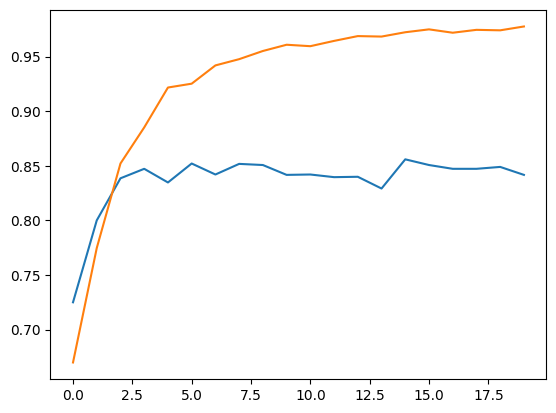

In [46]:
from matplotlib import pyplot as plt
plt.plot(results["test_acc"])
plt.plot(results["train_acc"])

In [27]:
from torchmetrics.classification import F1Score

f1_fn = F1Score(task="binary", num_labels=5)

In [28]:
type(f1_fn)

torchmetrics.classification.f_beta.BinaryF1Score

In [ ]:
x=torch.rand((16,2))

In [ ]:
x.dtype

In [ ]:
y,X,offset=collate_batch([["The sun rises in the east and sets in the west.",0]])

In [ ]:
y,X,offset

In [ ]:
new_model.eval()

# Setup test loss and test accuracy values
test_loss, test_acc = 0, 0

# Turn on inference context manager
with torch.inference_mode():
    
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    test_pred_logits = new_model(X, offset)

    # 2. Calculate and accumulate loss
    # loss = loss_fn(test_pred_logits, y)
    # test_loss += loss.item()

    # Calculate and accumulate accuracy
    test_pred_labels = test_pred_logits.argmax(dim=1)
    # test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

In [ ]:
test_pred_labels,test_pred_logits

In [ ]:
# from pathlib import Path

# def save_model(model: torch.nn.Module, target_dir: str, model_name: str):
#     # Create target directory
#     target_dir_path = Path(target_dir)
#     target_dir_path.mkdir(parents=True, exist_ok=True)

#     # Create model save path
#     model_save_path = target_dir_path / model_name

#     # Save the model state_dict()
#     print(f" Saving model to: {model_save_path}")
#     torch.save(obj=model.state_dict(), f=model_save_path)
    
# save_model(
#     model=model, target_dir="models", model_name=f"first_model.pth"
# )


In [ ]:
new_model = TextClassificationModel(vocab_size, embed_size, num_class).to(device)
new_model.load_state_dict(torch.load("models/first_model.pth"))

In [ ]:
import pickle

data = pickle.load(open("data.pkl", "rb"))
rules = open("samples.txt", "r").readlines()
rules = [i[0:-1] for i in rules]
exemplars=pickle.load(open("samples.pkl", "rb"))

In [ ]:
for text,label in data[:16]:
    print(label)

In [ ]:
from data_setup import get_dataloaders

tr_dl, ts_dl, vl = get_dataloaders("data.pkl", 16)

In [ ]:
x=next(iter(tr_dl))

In [ ]:
x[0].unsqueeze(1).shape

In [ ]:
# for i,j in zip(rules,exemplars):
#     print(i," ",j)

In [ ]:
import re

y = []

for text, label in data[:]:
    temp = []
    for i in range(len(rules)):
        compiled_pattern = re.compile(rules[i], re.IGNORECASE)
        if bool(compiled_pattern.search(text)) and label == 0:
            temp.append(0)
        else:
            temp.append(1)
    y.append(temp)

In [ ]:
len(y[0]),len(y)

In [ ]:
data=[i for i,j in data]

In [ ]:
rule_data = [[data[i],y[i]] for i in range(2822)]

In [ ]:
len(rule_data),len(rule_data[0]),len(rule_data[4][1])

In [ ]:
pickle.dump(rule_data,open("rule_data.pkl","wb"))

In [ ]:
a=pickle.load(open("rule_data.pkl", "rb"))

In [ ]:
len(a),len(a[0])

In [ ]:
for i in a:
    print(i[0],i[1])
    break

In [ ]:
data = [[preprocess(i[0]), i[1]] for i in a]

In [ ]:
a[0][0]

In [ ]:
def preprocess(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text)
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(r"#[A-Za-z0-9]*", "", text)
    text = re.sub(r"https?:\/\/\S+", "", text)
    text = re.sub(r"[\n]", " ", text)
    text = re.sub(r"['\",*%$#()]", " ", text)
    text = re.sub(r"[.]", " . ", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    return text.strip()

In [ ]:
data = [[preprocess(i[0]), i[1]] for i in rule_data]

In [ ]:
len(data),len(data[0]),len(data[0][1])

In [ ]:
from data_setup import get_dataloaders

train_dl,test_dl,vl=get_dataloaders("rule_data.pkl",16)

In [ ]:
y, x, o = next(iter(train_dl))

In [ ]:
y.shape,x.shape

In [ ]:
4460/16

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

torch.set_default_device(device)

In [ ]:
for b,d in enumerate(train_dl):
    print(b,d,d[1].shape)
    break

In [ ]:
d[0].shape,d[1].shape,d[2].shape

In [ ]:
import torch
y=torch.rand((16,43))
y_pred=torch.rand((16,43))

In [ ]:
temp=y-y_pred

In [ ]:
c=0
for i in temp.reshape(-1):
    c+=1

In [ ]:
c = 0
num_classes = 5
for i in range(num_classes):
    if (y[i] - y_pred[i]).abs() < 0.5:
        c += 1
acc = c / num_classes
acc

In [15]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim.adam
import torch
import torch.nn as nn

In [16]:
class ClassificationNetwork(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_nodes, num_class, embedding_matrix):
        super(ClassificationNetwork, self).__init__()

        # self.glove_embedding = nn.EmbeddingBag.from_pretrained(
        #     embedding_matrix, freeze=True
        # )
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.dense_block = nn.Sequential(
            nn.Linear(embed_dim, num_nodes),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(num_nodes, num_class),
        )

        self.embedding.apply(self.init_weights)
        self.dense_block.apply(self.init_weights)

    def init_weights(self, layer):
        initrange = 0.5

        if isinstance(layer, nn.Linear or nn.EmbeddingBag):
            layer.weight.data.uniform_(-initrange, initrange)
            layer.bias.data.zero_()

    def forward(self, text, offsets):
        # combined_embedding = torch.cat(
        #     [self.embedding(text, offsets), self.glove_embedding(text, offsets)],
        #     dim=-1,
        # )
        embedded = self.embedding(text, offsets)
        return self.dense_block(embedded)


In [19]:
model = ClassificationNetwork(500, 20, 50, 2, None)


optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, "max", patience=3, verbose=True)


In [20]:
type(scheduler)

torch.optim.lr_scheduler.ReduceLROnPlateau

In [14]:
import pickle
import os

eval_dict = {}

folder_path = "./results/"

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    res = pickle.load(open(file_path, "rb"))
    eval_dict[filename] = max(res["test_acc"])

In [15]:
sorted(eval_dict.items())

[('1024nodes_1024embed_0.001lr_results.pkl', 0.8996069183889425),
 ('1024nodes_1024embed_3e-4lr_results.pkl', 0.7935461458170189),
 ('256nodes_1024embed_3e-4lr_results.pkl', 0.7833461311628234),
 ('classification_model_dropout0.5_2508_results.pkl', 0.8996855346661694),
 ('classification_model_dropout0.5_2608_with_embeddings_results.pkl',
  0.831289308251075),
 ('classification_model_dropout0.6_2508_results.pkl', 0.8973270441001316),
 ('model_with_layernorm_256nodes_1024embed_0.001lr_results.pkl',
  0.8996270310203984),
 ('model_with_layernorm_256nodes_1024embed_3e-4lr_32batch_results.pkl',
  0.8943206314687375),
 ('rule_model_with_layernorm_1024nodes_1024embed_3e-4lr_32batch_results.pkl',
  0.8921924299663968)]

In [ ]:
res1=pickle.load(open("results\classification_model_dropout0.6_2508_results.pkl","rb"))
res2=pickle.load(open("results\classification_model_dropout0.5_2508_results.pkl","rb"))

In [39]:
import pandas as pd

In [44]:
pd.DataFrame(res1).sort_values(by="test_f1",ascending=False),pd.DataFrame(res2).sort_values(by="test_f1",ascending=False)

(    train_loss  train_f1  train_acc  test_loss   test_f1  test_acc
 17    0.037894  0.989567   0.990423   0.343799  0.887422  0.897327
 11    0.112145  0.957060   0.962558   0.311856  0.884228  0.892610
 13    0.082809  0.968599   0.970766   0.325911  0.881725  0.896148
 18    0.033232  0.988797   0.990423   0.355096  0.880266  0.887893
 12    0.086164  0.967595   0.969758   0.316964  0.876140  0.893789
 10    0.135249  0.948615   0.953125   0.319740  0.875109  0.883019
 8     0.173269  0.921297   0.927275   0.317038  0.871735  0.883019
 14    0.073092  0.970906   0.973286   0.338545  0.867581  0.890252
 19    0.036350  0.991695   0.992440   0.374309  0.865950  0.878302
 16    0.049480  0.980592   0.984375   0.349396  0.865330  0.887972
 9     0.158399  0.932475   0.941028   0.306827  0.863489  0.877123
 15    0.055742  0.982230   0.981351   0.349301  0.862266  0.893789
 7     0.225380  0.899866   0.909634   0.325797  0.853238  0.879481
 6     0.248921  0.887587   0.900562   0.334898 